In [63]:
# Import system requirements
import sys, os

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use NetworkX graphic package to create a signed network
import networkx as nx
import random

from cdlib import algorithms

In [105]:
# Import data

dataset = 'sp100' # values: 'asset_class','ftse','sectors','sp100'

os.chdir("../data_modified")

corr_tensor = np.load('%s_corr.npy' % (dataset)) #list of correlation matrices for each date
dates = np.load('%s_dates.npy' % (dataset)) #list of timestamps
nodes = np.load('%s_nodes.npy' % (dataset)) #list of tickers

num_examples = corr_tensor.shape[0] #number of dates
dim = corr_tensor.shape[1] #number of assets

sp500_df = pd.read_csv("sp500_df.csv")

In [65]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
   # density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def clique_size(clique):
    return len(clique)

In [66]:
corr_mat = corr_tensor[int(num_examples/2), :, :].copy() #take the correlation matrix for a specific date (for visualization)
corr_mat[(corr_mat > -1*0.5) & (corr_mat < 0.5)] = 0 #arbitrary threshold, for visualization purposes
G = make_graph(corr_mat, nodes, 'corr')

In [67]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)] #list of subgraphs
myGraph = S[0].copy()
for node in S[0].nodes():
    if node not in sp500_df.columns.values:
        myGraph.remove_node(node)

In [ ]:
com = algorithms.spinglass(myGraph) #this is the largest graph

In [ ]:
original_part = com.to_node_community_map()
for key in original_part.keys():
    original_part[key] = original_part[key][0] #just to make formatting consistent

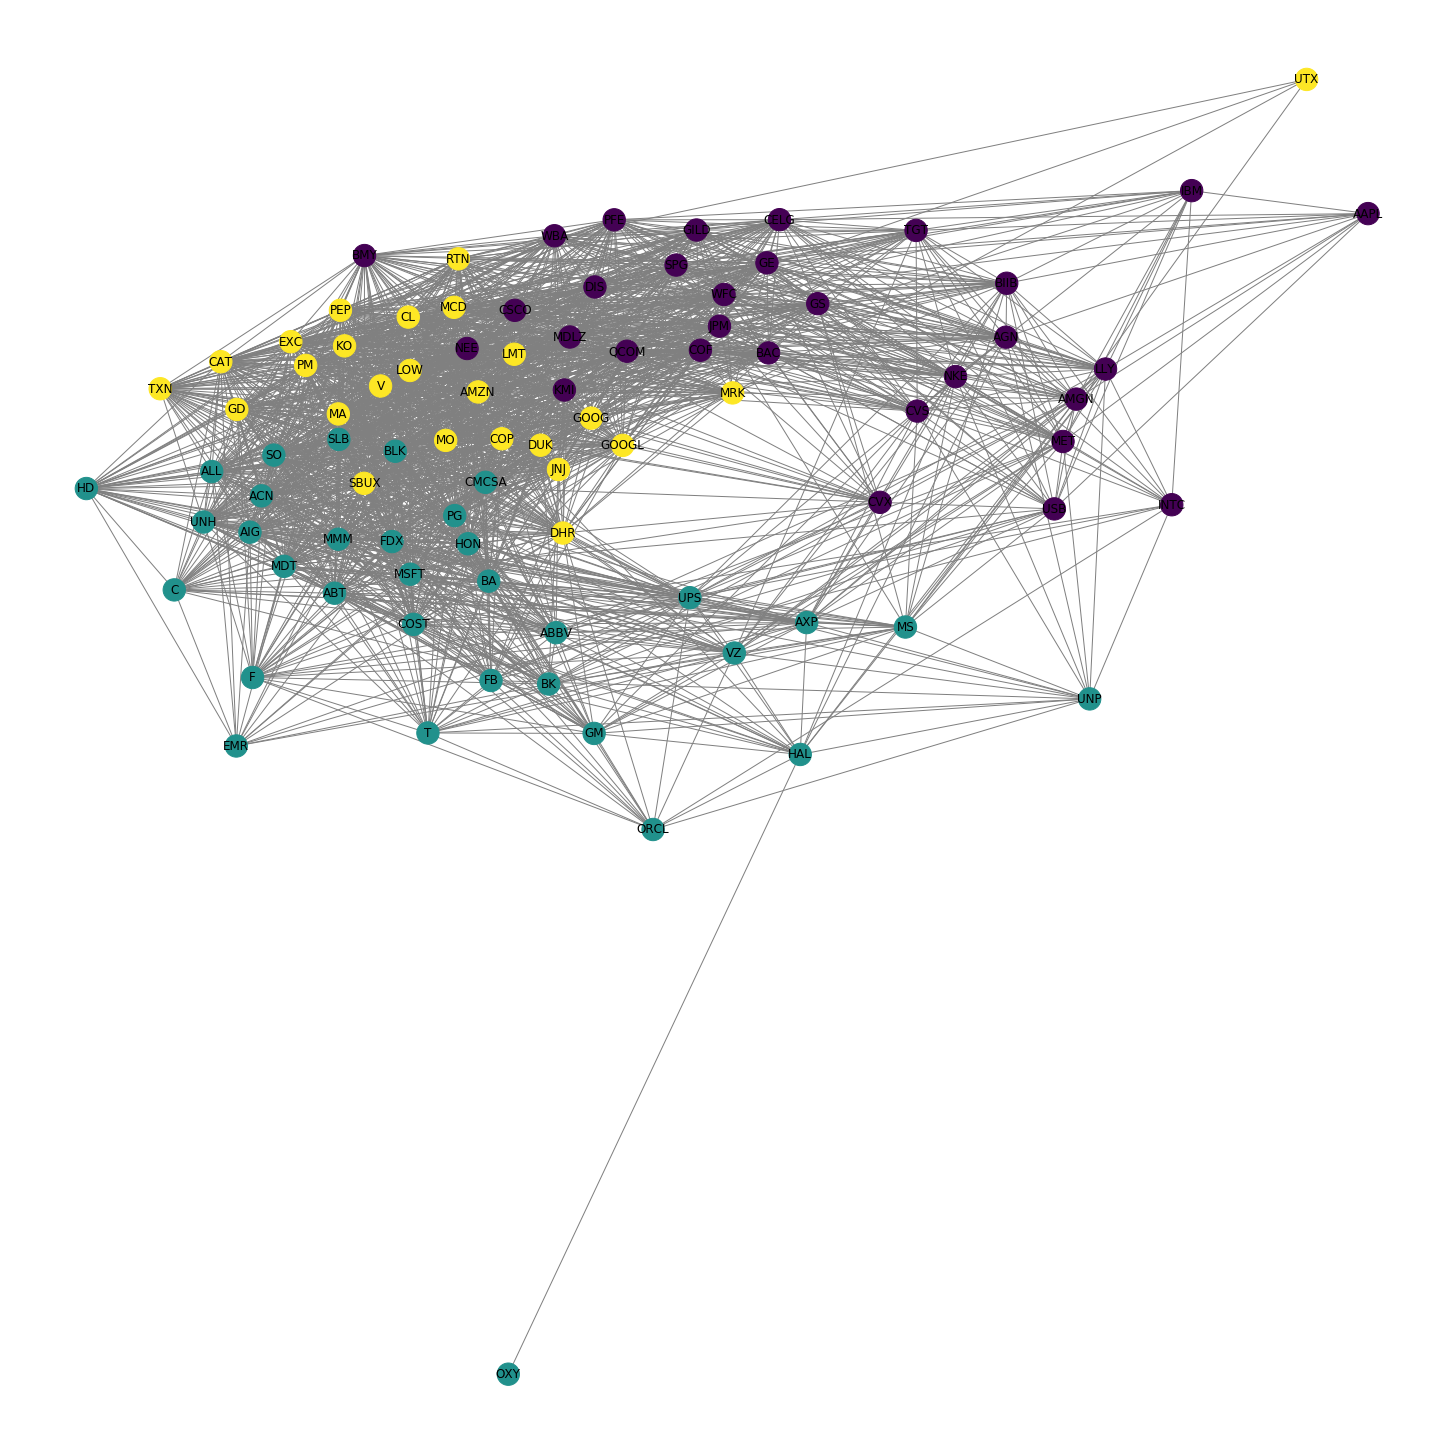

In [68]:
values = [original_part.get(node) for node in myGraph.nodes()]

#print(values)
plt.figure(3,figsize=(20,20))
nx.draw_spring(G, node_color = values, node_size=500, with_labels=True, edge_color = 'grey')
plt.show()

In [69]:
#sector grouping

os.chdir("../data_modified")
df = pd.read_csv("SP500_Sectors.csv")
sector_df = df[['Ticker', 'Sector']]
sector_df = sector_df.replace({'Sector':{'Communication Services': 1, 'Consumer Discretionary': 2, 'Consumer Staples': 3, 'Energy': 4,
                           'Financials': 5, 'Health Care': 6, 'Industrials': 7, 'Information Technology': 8, 'Materials': 9,
                           'Real Estate': 10, 'Utilities': 11}})

labels = {}
for node in myGraph.nodes():
    if node in sector_df['Ticker'].to_list():
        node_label = sector_df.loc[sector_df['Ticker'] == node,'Sector'].tolist()[0]
    else:
        new_node = 0
    labels[node] = node_label


In [99]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

def community_layout(g, partition, sub_partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=2500.)
    
    pos_sub_communities = _position_sub_communities(g, sub_partition, scale=3000)

    pos_nodes = _position_nodes(g, sub_partition)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node] + pos_sub_communities[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.shell_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _position_sub_communities(g, sub_partition, **kwargs):
    
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, sub_partition)

    communities = set(sub_partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.circular_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in sub_partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges

def _position_nodes(g, sub_partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in sub_partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph,scale=len(subgraph)*50, **kwargs) #
        pos.update(pos_subgraph)
    return pos


# pos = community_layout(G, original_part)
# values = [original_part.get(node) for node in G.nodes()]

# plt.figure(3,figsize=(30,30))
# nx.draw(G, pos, node_color = values, node_size=700, with_labels=False, edge_color = 'grey')
# nx.draw_networkx_labels(G,pos,labels,font_size=16)
# plt.show()

In [91]:
def create_np(df, name):

    i=0
    corr_tensor = []
    dates = []
    while i < len(df):
        sub_df = df.iloc[i:min(i+30,len(df))]
        corr = sub_df.corr(method='pearson')
        corr_np = corr.to_numpy()
        corr_tensor.append(corr_np)
        dates.append(df.index.values[i])
        i += 30
    corr_tensor = np.asarray(corr_tensor)
    tmp_dates = [pd.to_datetime(x) for x in dates]
    dates = np.asarray(tmp_dates)
    nodes = np.asarray(df.columns.values)

    np.save(name + '_corr', corr_tensor)
    np.save(name + '_dates', dates)
    np.save(name + '_nodes', nodes)

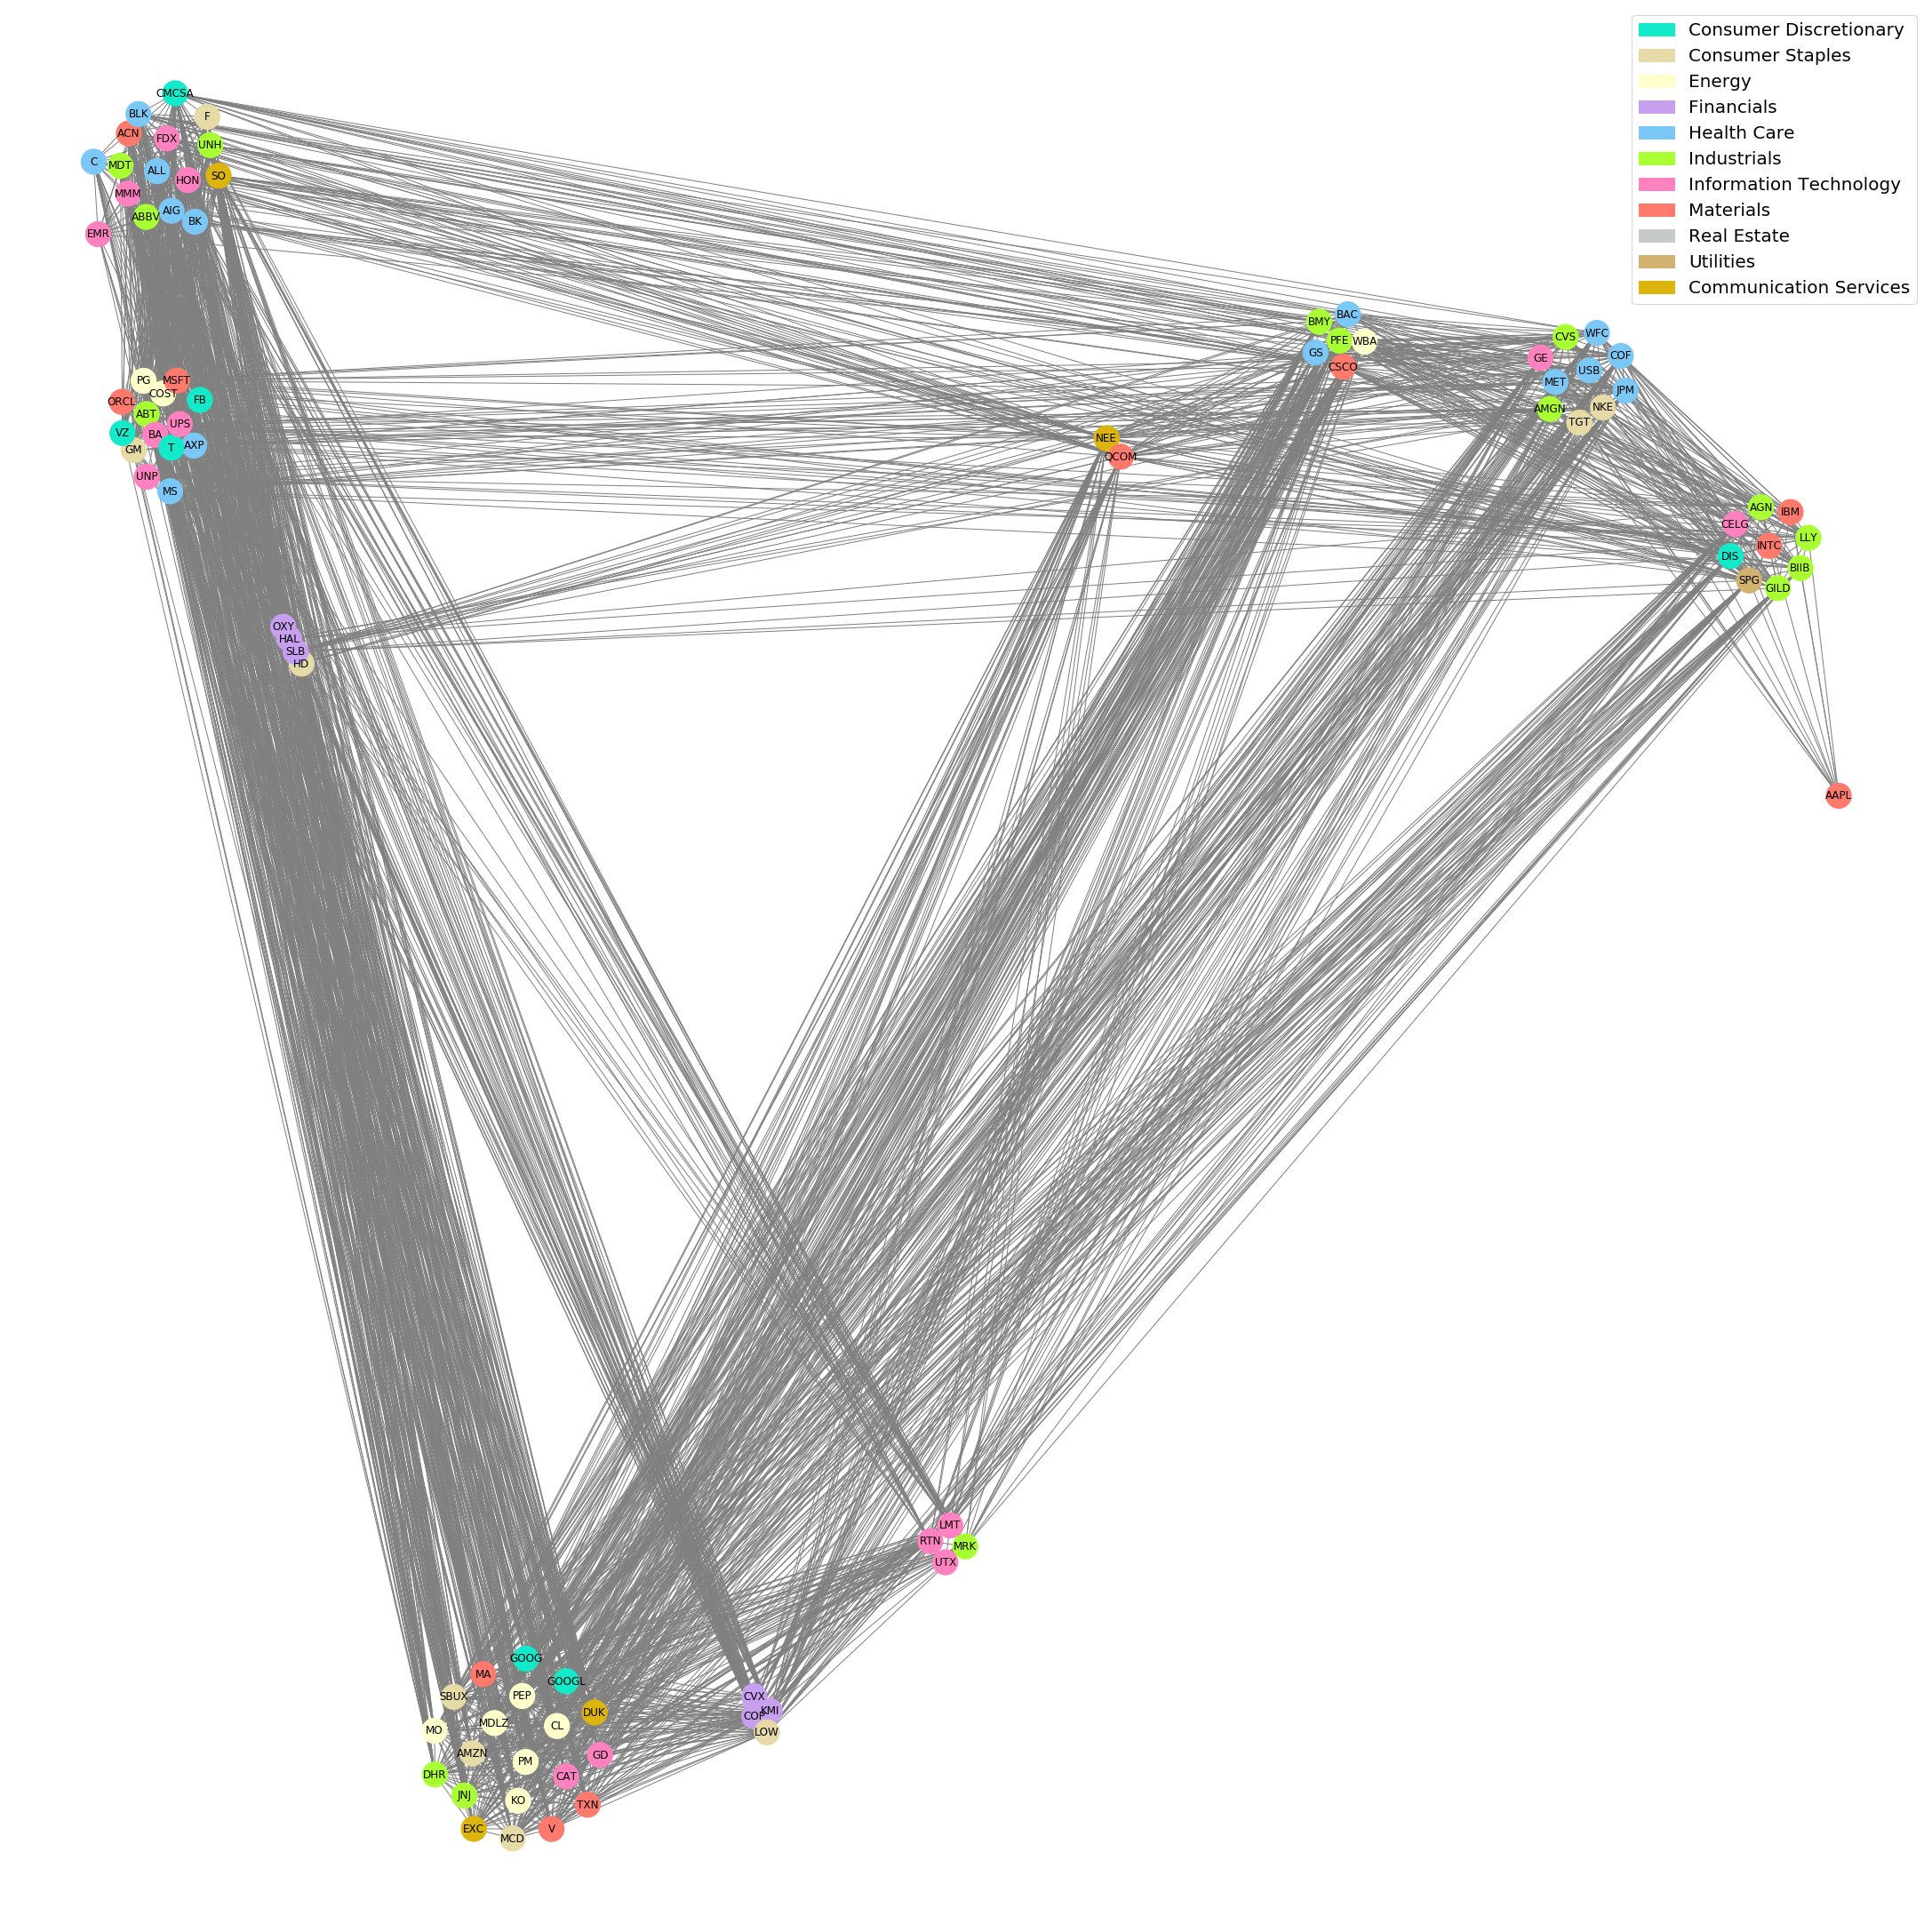

In [28]:
import collections
res = collections.defaultdict(list) 
for key, val in sorted(original_part.items()):
    res[val].append(key) 

myQueue = []
for val in res.values():
    myQueue.append((val, 1))

num_iters = 2

part = {}
    
while myQueue[0][1] < num_iters:
    val, i = myQueue[0]
    #print(i)
    myQueue = myQueue[1:]
    
#     os.chdir("../data_generation")
#     sp500_df = pd.read_csv("sp500_df.csv") 
#     df = sp500_df[val].copy()
    
#     os.chdir("../data_modified")
#     create_np(df, "module_" + val[0])
    
    corr_tensor = np.load('%s_corr.npy' % ("module_" + val[0])) #list of correlation matrices for each date
    dates = np.load('%s_dates.npy' % ("module_" + val[0])) #list of timestamps
    nodes = np.load('%s_nodes.npy' % ("module_" + val[0])) #list of tickers

    num_examples = corr_tensor.shape[0] #number of dates
    dim = corr_tensor.shape[1] #number of assets
    
    corr_mat = corr_tensor[int(num_examples/2), :, :].copy() #take the correlation matrix for a specific date (for visualization)
#     corr_mat[(corr_mat > -1*0.5) & (corr_mat < 0.5)] = 0 #arbitrary threshold, for visualization purposes
    corr_mat[(corr_mat < 0.5)] = 0 #arbitrary threshold, for visualization purposes

    new_G = make_graph(corr_mat, nodes, 'corr')
    
    # Find modularity
    temp_part = community_louvain.best_partition(new_G)
    if part != {}:
        max_value = max(part.values())
        for key in temp_part.keys():
            temp_part[key] = temp_part[key] + (max_value+1)       
    part.update(temp_part)
    mod = community_louvain.modularity(part,new_G)
    
    res = collections.defaultdict(list) 
    for key, val in sorted(part.items()):
        res[val].append(key) 
    
    for val in res.values():
        myQueue.append((val, i+1))

# Plot, color nodes using community structure    
pos = community_layout(myGraph, original_part, part)
values = [label for label in labels.values()]
plt.figure(3,figsize=(30,30))
my_colors = ['aqua','beige','ivory','lavender','lightblue', 'lime', 'pink','salmon','silver','tan','gold']
values = ['xkcd:' + my_colors[i-1] for i in values]

nx.draw(myGraph, pos, node_color = values, node_size=800, with_labels=True, edge_color = 'grey')
#nx.draw_networkx_labels(G,pos,labels,font_size=16)

import matplotlib.patches as mpatches

patch1 = mpatches.Patch(color='xkcd:aqua', label='Consumer Discretionary')
patch2 = mpatches.Patch(color='xkcd:beige', label='Consumer Staples')
patch3 = mpatches.Patch(color='xkcd:ivory', label='Energy')
patch4 = mpatches.Patch(color='xkcd:lavender', label='Financials')
patch5 = mpatches.Patch(color='xkcd:lightblue', label='Health Care')
patch6 = mpatches.Patch(color='xkcd:lime', label='Industrials') 
patch7 = mpatches.Patch(color='xkcd:pink', label='Information Technology')
patch8 = mpatches.Patch(color='xkcd:salmon', label='Materials')
patch9 = mpatches.Patch(color='xkcd:silver', label='Real Estate')
patch10 = mpatches.Patch(color='xkcd:tan', label='Utilities')
patch11 = mpatches.Patch(color='xkcd:gold', label='Communication Services')

plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6,patch7,patch8,patch9,patch10,patch11],fontsize=20)

plt.show() 